In [56]:
# gen libs
import xarray as xr
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import time

# libs for poincaré
from osa import Client

# emc3 submodule
import xemc3

#vtk libs
from tvtk.api import tvtk
from mayavi.scripts import mayavi2
from PyQt5 import QtCore
import sip
import vtk
from mayavi import mlab
%gui qt

In [2]:
class grid:
    def __init__(self, ds, ngrid_cart = None, inc_r = [None, None], inc_t = [None, None], inc_p = [None, None]):
        """
        Args:
         - xarray, ds is a dataset containing the W7X data
         - int, ngrid_cart is cartesian grid resolution 
         - list dim 2 (min,max), inc_r, inc_t, inc_p is the minmax of the grid indexes in r, theta and phi direction
         
        Out:
         - grid object, both cartesian meshgrid of toroidal and cartesian grid, can also get as flattened arrays
        
        Note: Periodic boundary conditions is added in theta direction
        """
        dgrid = np.asarray( ds.R_bounds.mean(dim=("delta_r", "delta_theta", "delta_phi")) )[inc_r[0]:inc_r[1],
                                                                                             inc_t[0]:inc_t[1],
                                                                                             inc_p[0]:inc_p[1]].shape
        
        self.R, self.theta, self.phi, self.tor_z = np.ones(dgrid)*np.nan, np.ones(dgrid)*np.nan, np.ones(dgrid)*np.nan, np.ones(dgrid)*np.nan
        
        self.R = np.asarray( ds.R_bounds.mean(dim=("delta_r", "delta_theta", "delta_phi")) )[inc_r[0]:inc_r[1],
                                                                                             inc_t[0]:inc_t[1],
                                                                                             inc_p[0]:inc_p[1]]

        
        self.tor_z = np.asarray(ds.z_bounds.mean(dim=("delta_r", "delta_theta", "delta_phi")))[inc_r[0]:inc_r[1],
                                                                                               inc_t[0]:inc_t[1],
                                                                                               inc_p[0]:inc_p[1]]

        self.phi = np.asarray( ds.phi_bounds.mean(dim="delta_phi") )[inc_p[0]:inc_p[1]]

        
        self.tor_x = np.asarray( self.R * np.cos(self.phi) )
        self.tor_y = np.asarray( self.R * np.sin(self.phi) )
        if ngrid_cart == None:
            ngrid_cart = 100
        
        ivl_p = int(inc_p[1] - inc_p[0])
        self.cart_x, self.cart_y, self.cart_z = np.meshgrid(np.linspace(np.min(self.tor_x),np.max(self.tor_x), ngrid_cart), 
                                                            np.linspace(np.min(self.tor_y),np.max(self.tor_y), ngrid_cart*ivl_p//36), 
                                                            np.linspace(np.min(self.tor_z),np.max(self.tor_z), ngrid_cart),
                                                            indexing = "ij")
     
        self.cartflat = np.ones((self.cart_x.shape[0]*self.cart_x.shape[1]*self.cart_x.shape[2], 3) )*np.nan
        self.cartflat[:,0] = self.cart_x.flatten()
        self.cartflat[:,1] = self.cart_y.flatten()
        self.cartflat[:,2] = self.cart_z.flatten()
        
        self.torflat = np.ones((self.tor_x.shape[0]*self.tor_x.shape[1]*self.tor_x.shape[2], 3))*np.nan
        self.torflat[:,0] = self.tor_x.flatten()
        self.torflat[:,1] = self.tor_y.flatten()
        self.torflat[:,2] = self.tor_z.flatten()

In [3]:
folder = r"C:\Users\joag\Documents\Notebooks"
path_timeseriesdata_emc3 = folder  + r"\N01.nc"
path_timeseriesdata_emc3
ds_tot = xr.open_dataset(path_timeseriesdata_emc3)

In [4]:
ds_tot

<xarray.Dataset>
Dimensions:                       (delta_phi: 2, delta_r: 2, delta_theta: 2, phi: 36, r: 139, theta: 512, time: 66)
Coordinates:
    R_bounds                      (r, theta, phi, delta_r, delta_theta, delta_phi) float64 ...
    z_bounds                      (r, theta, phi, delta_r, delta_theta, delta_phi) float64 ...
    phi_bounds                    (phi, delta_phi) float64 ...
Dimensions without coordinates: delta_phi, delta_r, delta_theta, phi, r, theta, time
Data variables: (12/34)
    _plasma_map                   (r, theta, phi) int64 ...
    ne                            (time, r, theta, phi) float64 ...
    nZ1                           (time, r, theta, phi) float64 ...
    nZ2                           (time, r, theta, phi) float64 ...
    nZ3                           (time, r, theta, phi) float64 ...
    nZ4                           (time, r, theta, phi) float64 ...
    ...                            ...
    IMPURITY_IONIZATION_SOURCE_0  (time, r, theta, phi) float64 ...
    IMPURITY_IONIZATION_SOURCE_1  (time, r, theta, phi) float64 ...
    IMPURITY_NEUTRAL_0            (time, r, theta, phi) float64 ...
    IMP_RADIATION_0               (time, r, theta, phi) float64 ...
    FLUX_CONSERVATION_0           (r, theta, phi) float64 ...
    LG_CELL_0                     (r, theta, phi) float64 ...

In [5]:
ds_tsdata_emc3 = ds_tot.isel(time = slice(-20,None))

In [6]:
mean_sel = ds_tsdata_emc3.mean(dim = 'time')
std_sel = ds_tsdata_emc3.std(dim = 'time')
std_tot = ds_tsdata_emc3.std()

C:\Users\joag\AppData\Local\Continuum\anaconda3\envs\Mayavi\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\joag\AppData\Local\Continuum\anaconda3\envs\Mayavi\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\joag\AppData\Local\Continuum\anaconda3\envs\Mayavi\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [7]:
ds_tsdata_emc3.R_bounds.mean(dim=("delta_r", "delta_theta", "delta_phi")).shape

(139, 512, 36)

In [8]:
grid_meanmean_sel = grid(ds = mean_sel, inc_r = [20, 138], inc_t = [0, 512], inc_p = [0, 4])
dimsg = grid_meanmean_sel.tor_x.shape[::-1]
sg_meanmean = tvtk.StructuredGrid(dimensions = dimsg)
sg_meanmean.points = grid_meanmean_sel.torflat
sg_meanmean.point_data.scalars = np.asarray(mean_sel.Te)[20:138,0:512,0:4].flatten()
sg_meanmean.point_data.scalars.name = "Te"

In [9]:
"""
Plotting the actual values in the W7X grid with the electron temperature as a test.
"""
# clear the field
mlab.clf()
#add the dataset to the pipeline, the principle is to add several object on top of each other
src_emc3 = mlab.pipeline.add_dataset(sg_meanmean)
# make a cut object to cut the 3D volum in slices in a user defined direction
cut_emc3 = mlab.pipeline.scalar_cut_plane(src_emc3)
# make a contour plot of the scalar field
cont_emc3 = mlab.pipeline.iso_surface(cut_emc3)
# add the outline of the 3d domain
mlab.outline()
# add axis to the plot
mlab.axes()

In [10]:
# importing widget libs to make interactive plots
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

In [11]:
std_sel
# std_tot

<xarray.Dataset>
Dimensions:                       (delta_phi: 2, delta_r: 2, delta_theta: 2, phi: 36, r: 139, theta: 512)
Coordinates:
    R_bounds                      (r, theta, phi, delta_r, delta_theta, delta_phi) float64 ...
    z_bounds                      (r, theta, phi, delta_r, delta_theta, delta_phi) float64 ...
    phi_bounds                    (phi, delta_phi) float64 0.0 ... 0.6283
Dimensions without coordinates: delta_phi, delta_r, delta_theta, phi, r, theta
Data variables: (12/34)
    _plasma_map                   (r, theta, phi) float64 0.0 0.0 ... 0.0 0.0
    ne                            (r, theta, phi) float64 nan nan ... nan nan
    nZ1                           (r, theta, phi) float64 nan nan ... nan nan
    nZ2                           (r, theta, phi) float64 nan nan ... nan nan
    nZ3                           (r, theta, phi) float64 nan nan ... nan nan
    nZ4                           (r, theta, phi) float64 nan nan ... nan nan
    ...                            ...
    IMPURITY_IONIZATION_SOURCE_0  (r, theta, phi) float64 nan nan ... nan nan
    IMPURITY_IONIZATION_SOURCE_1  (r, theta, phi) float64 nan nan ... nan nan
    IMPURITY_NEUTRAL_0            (r, theta, phi) float64 nan nan ... nan nan
    IMP_RADIATION_0               (r, theta, phi) float64 nan nan ... nan nan
    FLUX_CONSERVATION_0           (r, theta, phi) float64 nan nan ... nan nan
    LG_CELL_0                     (r, theta, phi) float64 nan nan ... nan nan

In [12]:
cl = Client("http://esb.ipp-hgw.mpg.de:8280/services/w7xfp?wsdl")

In [13]:
# should be 21
cl.service.getProfilesNumberOfKnots()

21

In [14]:
tracer = Client('http://esb.ipp-hgw.mpg.de:8280/services/FieldLineProxy?wsdl')

''' set the start points (R, phi, Z) for the tracing... '''
p = tracer.types.Points3D()
p.x1 = np.linspace(5.64, 6.3, 30)
p.x2 = np.zeros(30)
p.x3 = np.zeros(30)

''' set a coil coilconfiguration ... '''
coilconfig = tracer.types.MagneticConfig()

''' e.g. using a coilconfig ID from CoilsDB: 
    1 : 'w7x standard case', 3 : 'low iota', 4 : 'high iota', 5 : 'low mirror', etc. '''
coilconfig.configIds = [0] 

''' you could also create your own coil coilconfigurations 
    e.g. use only all type 3 of the non-planar sc coils from w7x: '''
#coilconfig.coilsIds = [162, 167, 172, 177, 182, 187, 192, 197, 202, 207]
#coilconfig.coilsIdsCurrents = [9993.92, 9993.92, 9993.92, 9993.92, 9993.92, 9993.92, 9993.92, 9993.92, 9993.92, 9993.92]

''' you can use a grid for speeding up your requests. 
    Without a grid all tracing steps will be calculated by using Biot-Savart 
'''
my_grid = tracer.types.CylindricalGrid()
my_grid.RMin = 4.05
my_grid.RMax = 6.75
my_grid.ZMin = -1.35
my_grid.ZMax = 1.35
my_grid.numR = 181
my_grid.numZ = 181
my_grid.numPhi = 481

g = tracer.types.Grid()
g.cylindrical = my_grid
g.fieldSymmetry = 5

coilconfig.grid = g


pctask = tracer.types.PoincareInPhiPlane()
pctask.numPoints = 300
pctask.phi0 = [0.0]
                     
task = tracer.types.Task()
task.step = 0.01
task.poincare = pctask

''' you can use a Machine object for a limitation of the tracing region. 
    This sample uses a torus model (id = 164) from ComponentsDB: '''
machine = tracer.types.Machine()
machine.meshedModelsIds = [164] 
machine_grid = tracer.types.CartesianGrid()
machine_grid.XMin = -7
machine_grid.XMax = 7
machine_grid.YMin = -7
machine_grid.YMax = 7
machine_grid.ZMin = -1.5
machine_grid.ZMax = 1.5
machine_grid.numX = 400
machine_grid.numY = 400
machine_grid.numZ = 100

machine.grid = machine_grid
# machine = None

''' make a request to the web service: '''
result = tracer.service.trace(p, coilconfig, task, machine, None)

In [15]:
"""
Y-slices of raw data.
"""
# %matplotlib
ds_sel_Te = ds_tsdata_emc3.Te[:,20:138,0:512,:]
def plot_emc3toroidal(itime, ip):
    figemc3 = plt.figure(figsize=(15,15))
    axemc3 = figemc3.add_subplot()
    clev = np.arange(ds_sel_Te[itime,:,:,ip].min(),
                     ds_sel_Te[itime,:,:,ip].max(),.5)
    cemc3 = axemc3.contourf(grid_meanmean_sel.R[:,:,ip], 
                            grid_meanmean_sel.tor_z[:,:,ip], 
                            ds_sel_Te[itime,:,:,ip], 
                            clev)
    figemc3.colorbar(cemc3)
    
    # Poincaré
    for i in range(0,len(result.surfs)):
        axemc3.scatter(result.surfs[i].points.x1, result.surfs[i].points.x3, s=0.1)
    
phislider = widgets.IntSlider(min = 0, max = 3, value = 0)
timeslider = widgets.IntSlider(min = 0, max = 19, value = 0)
interact(plot_emc3toroidal, itime = timeslider, ip = phislider)

interactive(children=(IntSlider(value=0, description='itime', max=19), IntSlider(value=0, description='ip', ma…

<function __main__.plot_emc3toroidal(itime, ip)>

In [16]:
"""
1. Define indices of edges near the x-point.
2. Inspect the noise of the Rz slices of these edges.
3. Do the interpolation on these region so that the data resembles image data.
4. Try different denoising techniques on the image data. For instance scikit wavelet denoising.
"""

def reduce_region_of_interest(ds, ds_param, region, iphi):
    """
    Args:
     - ds, xarray, time series dataset after slicing it into stationary solution
     - ds_param, xarray, instantenous(time index given) time series dataset of a selected parameter after slicing...
     - region, ndarray np.int64, indices in describing regional boundaries in r, theta, phi direction
    Out:
     - rcoord, zcoord, data_rzslice
     - dims = (n_region, direction, start/stop) = (2, 2) = (r/z, start/stop)
    """
    # dims = (time, r, theta, phi)
    rcoord = ds.emc3['R_corners'][region[0,0]:region[0,1], region[1,0]:region[1,1], iphi]
    zcoord = ds.emc3['z_corners'][region[0,0]:region[0,1], region[1,0]:region[1,1], iphi]
    data_rzslice = np.array(ds_param[region[0,0]:region[0,1], region[1,0]:region[1,1], iphi])
    return rcoord, zcoord, data_rzslice

In [17]:
"""
remember the grid has the dimensions (139,512,36) = (r, theta, phi)
only restrict in (r,theta)
"""

regstest = np.zeros((5, 2, 2), dtype = np.int64)
regstest[:,0,0] = 50
regstest[:,0,1] = 138
regstest[0,1,0] = 10
regstest[0,1,1] = 30
regstest[1,1,0] = 50
regstest[1,1,1] = 130
regstest[2,1,0] = 160
regstest[2,1,1] = 190
regstest[3,1,0] = 330
regstest[3,1,1] = 360
regstest[4,1,0] = 380
regstest[4,1,1] = 450

In [18]:
import warnings
warnings.simplefilter("ignore", UserWarning)

def plot_Te_zoomed(itime, ip, ireg):
    """
    Watch out for:
    MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
      c = plt.pcolormesh(R[:, :,ip],
    """
    rcoord, zcoord, data_rzslice = reduce_region_of_interest(ds = ds_tsdata_emc3,
                                                             ds_param = ds_tsdata_emc3.Te[itime],
                                                             region = regstest[ireg], iphi = ip)
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot()
    c = plt.pcolormesh(rcoord, zcoord, data_rzslice, cmap = plt.cm.jet, shading = 'auto')
    plt.colorbar(c, label="$T_e$")
    plt.xlabel("$R[m]$")
    plt.ylabel("$z[m]$")
#     plt.legend()
phislider = widgets.IntSlider(min = 0, max = 35)
timeslider = widgets.IntSlider(min = 0, max = 19)
regionslider = widgets.IntSlider(min = 0, max = len(regstest)-1, value=1)
interact(plot_Te_zoomed, itime = timeslider, ip = phislider, ireg = regionslider)

interactive(children=(IntSlider(value=0, description='itime', max=19), IntSlider(value=0, description='ip', ma…

<function __main__.plot_Te_zoomed(itime, ip, ireg)>

In [19]:
import os
import sys

In [20]:
#import the necessary functions from the previous scripts
loc_path_interpol_script = r"C:\Users\joag\Documents\Notebooks\W7X_intership"
fps = []
fps.append(loc_path_interpol_script + r"\make_parammesh_vtk.py")
fps.append(loc_path_interpol_script + r"\grid.py")
for path in fps:
    module_path = os.path.abspath(os.path.join(path))
    if module_path not in sys.path:
        sys.path.append(module_path)

In [21]:
from make_parammesh_vtk import make_parammesh_vtk
from grid import grid

In [22]:
grid?
# vtk.vtkStructuredGrid?

In [291]:
gridlist_timeseries = []
sgridlist = []
i = 0
for region in regstest:
    print("region[0]", region[0], "region[1]", region[1])
    # use ngrid_cart = 128 to have dimensions of powers of 2
    gridlist_timeseries.append( grid(ds_tsdata_emc3, ngrid_cart=32, inc_r= region[0],inc_t=region[1], inc_p = [0,4] ) )
    sg = tvtk.StructuredGrid(dimensions = gridlist_timeseries[i].tor_x.shape[::-1])
    sg.points = gridlist_timeseries[i].torflat
    sgridlist.append(sg)    
    i+=1

region[0] [ 50 138] region[1] [10 30]
region[0] [ 50 138] region[1] [ 50 130]
region[0] [ 50 138] region[1] [160 190]
region[0] [ 50 138] region[1] [330 360]
region[0] [ 50 138] region[1] [380 450]


In [274]:
# paramlist = []
# for i in range(regstest.shape[0]):
#     print(i)
#     # setting the time index to 0
#     parammes_r, notfound = make_parammesh_vtk(grid_obj = gridlist_timeseries[i],
#                                               sgrid = sgridlist[i], 
#                                               param_torgrid = np.array(ds_tsdata_emc3.Te[0,regstest[i,0,0]:regstest[i,0,1],
#                                                                                          regstest[i,1,0]:regstest[i,1,1], :4]) )
#     print(len(notfound))
#     paramlist.append(parammes_r)

In [275]:
# ts_paramlist = [[]]*ds_tsdata_emc3.Te.shape[0]
# len(ts_paramlist)
# ts_paramlist[1]
# ts_paramlist[1].append([1])
# ts_paramlist[1].append([1])
# ts_paramlist[1]

In [292]:
def makeparamlist(ds_param, sgridlist, gridlist, regions):
    """
    Args:
     - ds_param, xarray np.float64, parameter dataset
     - sgridlist, tvtk.StructuredGrid object, the W7X grid
     - gridlist, grid object
     - regions, ndarray np.int64, indices of the regions of interest
    Out:
     - ts_paramlist, list of ndarray np.float64, times series meshgrid of parameter values (nt,) (ix, iy, iz)
    """
    ds_param = np.array(ds_param)
    ts_paramlist = []
#     for t in range(ds_param.shape[0]):
    for t in range(2):
        paramlist = []
        for i in range(regions.shape[0]):
            print(i)
            # setting the time index to 0
            parammesh_r, notfound = make_parammesh_vtk(grid_obj = gridlist[i],
                                                       sgrid = sgridlist[i],
                                                       param_torgrid = ds_param[t,regstest[i,0,0]:regstest[i,0,1],
                                                                                regstest[i,1,0]:regstest[i,1,1],:] )
            paramlist.append(parammesh_r)
        ts_paramlist.append(paramlist)
    return ts_paramlist

In [293]:
pmesh_ts = makeparamlist(ds_param = ds_tsdata_emc3.Te, 
                         sgridlist = sgridlist, 
                         gridlist = gridlist_timeseries, 
                         regions = regstest)

0
1
2
3
4
0
1
2
3
4


In [294]:
print(len(pmesh_ts))
print(len(pmesh_ts[0]))
pmesh_ts[0][0].shape

2
5


(32, 3, 32)

In [295]:
def plot_interpol_regs(itime, ireg, iy):
    plt.figure(figsize=(10,10))
    im = plt.imshow(pmesh_ts[itime][ireg].T[::-1][:,iy])
    plt.colorbar(im)
timeslider = widgets.IntSlider(min = 0, max = len(pmesh_ts)-1, value=0)
yslider = widgets.IntSlider(min = 0, max = pmesh_ts[0][0].T[::-1].shape[1]-1, value=1)
regionslider = widgets.IntSlider(min = 0, max = len(regstest)-1, value=1)
interact(plot_interpol_regs, itime = timeslider, ireg = regionslider, iy = yslider)

interactive(children=(IntSlider(value=0, description='itime', max=1), IntSlider(value=1, description='ireg', m…

<function __main__.plot_interpol_regs(itime, ireg, iy)>

In [296]:
from skimage.restoration import denoise_wavelet, cycle_spin
from skimage import data, img_as_float
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio
import skimage.data

In [297]:
def compare_regplot(ogimg, denoised_img):
    fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (20,20))
    noisy = ax[0,0].imshow(ogimg)
    ax[0,0].set_title("Noisy")
    fig.colorbar(noisy, ax = ax[0,0])
    denoised = ax[0,1].imshow(denoised_img)
    ax[0,1].set_title("Denoised")
    fig.colorbar(denoised, ax = ax[0,1])
    noise = ax[1,0].imshow(ogimg - denoised_img)
    ax[1,0].set_title("Noise")
    fig.colorbar(noise, ax = ax[1,0])

Text(0.5, 1.0, 'Noise')

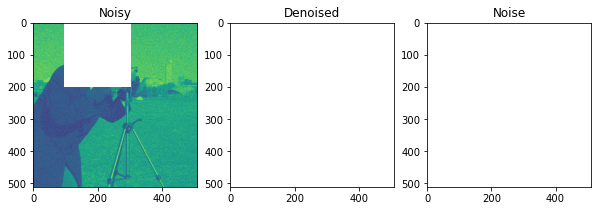

In [298]:
"""
As illustrated here, if there are NaN values in the data the shift-invariant wavelet denoising
method does not work and sets all the values of the resulting image to NaN.
"""

fig, ax = plt.subplots(ncols = 3, figsize = (10,10))
img = img_as_float(skimage.data.camera())
sigma = 0.1
img = img + sigma * np.random.standard_normal(img.shape)
img[:200,100:300] = np.ones(img[:200,100:300].shape)*np.nan
denoised = cycle_spin(img, func=denoise_wavelet, max_shifts=3)
ax[0].imshow(img)
ax[0].set_title("Noisy")
ax[1].imshow(denoised)
ax[1].set_title("Denoised")
ax[2].imshow(img - denoised)
ax[2].set_title("Noise")

In [303]:
def shiftinv_wavelet_denoising(tsdata, int_y = [0,pmesh_ts[0][0].shape[1]]):
    """
    Args:
     - tsdata, list of ndarray np.float64 (nt,)(nr,)(ix, iy, iz), list of times of list of regions of parameter mesh
     - int_phi, list of int, defining the interval in phi direction
    Out:
    """
    tik = time.time()
    denoised = []
    for t in range(len(tsdata)):
        for r in range(len(tsdata[0])):
            print(t*r)
            img = tsdata[t][r].T[::-1,int_y[0]:int_y[1]].copy()
            imgisnan = np.isnan(img)
            img[imgisnan] = np.zeros(img[imgisnan].shape)
            # multichannel = bool, do you have rgb/csv/hsv etc?, convert2ycbcr = bool, req multichannel = True
            # denoise_kwargs = dict(multichannel=False, convert2ycbcr=False, wavelet='db1', rescale_sigma=True)
            denoised_reg = cycle_spin(img, func=denoise_wavelet, max_shifts=img.shape)
    tok = time.time()
    return denoised, tok-tik

In [300]:
emc3_denoised, runtime = shiftinv_wavelet_denoising(tsdata = pmesh_ts) 

0


C:\Users\joag\AppData\Local\Continuum\anaconda3\envs\Mayavi\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\joag\AppData\Local\Continuum\anaconda3\envs\Mayavi\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
0


KeyboardInterrupt: 

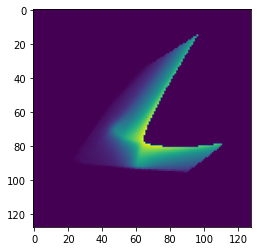

In [264]:
tik = time.time()
img0_reg = pmesh_ts[0][1].T[::-1][:,1:3].copy()
imgisnan = np.isnan(img0_reg)
img0_reg[imgisnan] = np.zeros(img0_reg[imgisnan].shape)
# plt.imshow(img0_reg[:,1])
# img0_reg[imgisnan] = np.ones(img0_reg[imgisnan].shape)*np.nan
plt.imshow(img0_reg[:,1])
# plt.imshow(paramlist[1].T[::-1][:,3])

In [265]:
np.where(imgisnan == True)[0].shape
img0_reg[:,0].shape

(128, 128)

In [266]:
# multichannel = bool, do you have rgb/csv/hsv etc?, convert2ycbcr = bool, req multichannel = True
# denoise_kwargs = dict(multichannel=False, convert2ycbcr=False, wavelet='db1', rescale_sigma=True)
denoised_reg = cycle_spin(img0_reg, func=denoise_wavelet, max_shifts=img0_reg.shape)
tok = time.time()

In [267]:
np.where(imgisnan == True)[0].shape
imgisnan.shape
np.where(np.isnan(denoised_reg) == True)[0].shape

(0,)

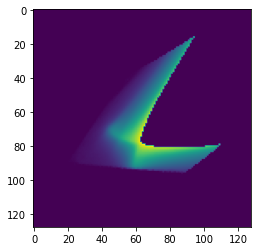

In [268]:
plt.imshow(denoised_reg[:,0])

In [269]:
# set values that were nan before the denoising back to nan
img0_reg[imgisnan] = np.ones(img0_reg[imgisnan].shape)*np.nan
denoised_reg[imgisnan] = np.ones(denoised_reg[imgisnan].shape)*np.nan

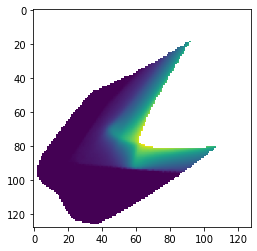

In [270]:
plt.imshow(denoised_reg[:,0])

2D shift-invariant denoising took  2414.8315229415894 seconds.


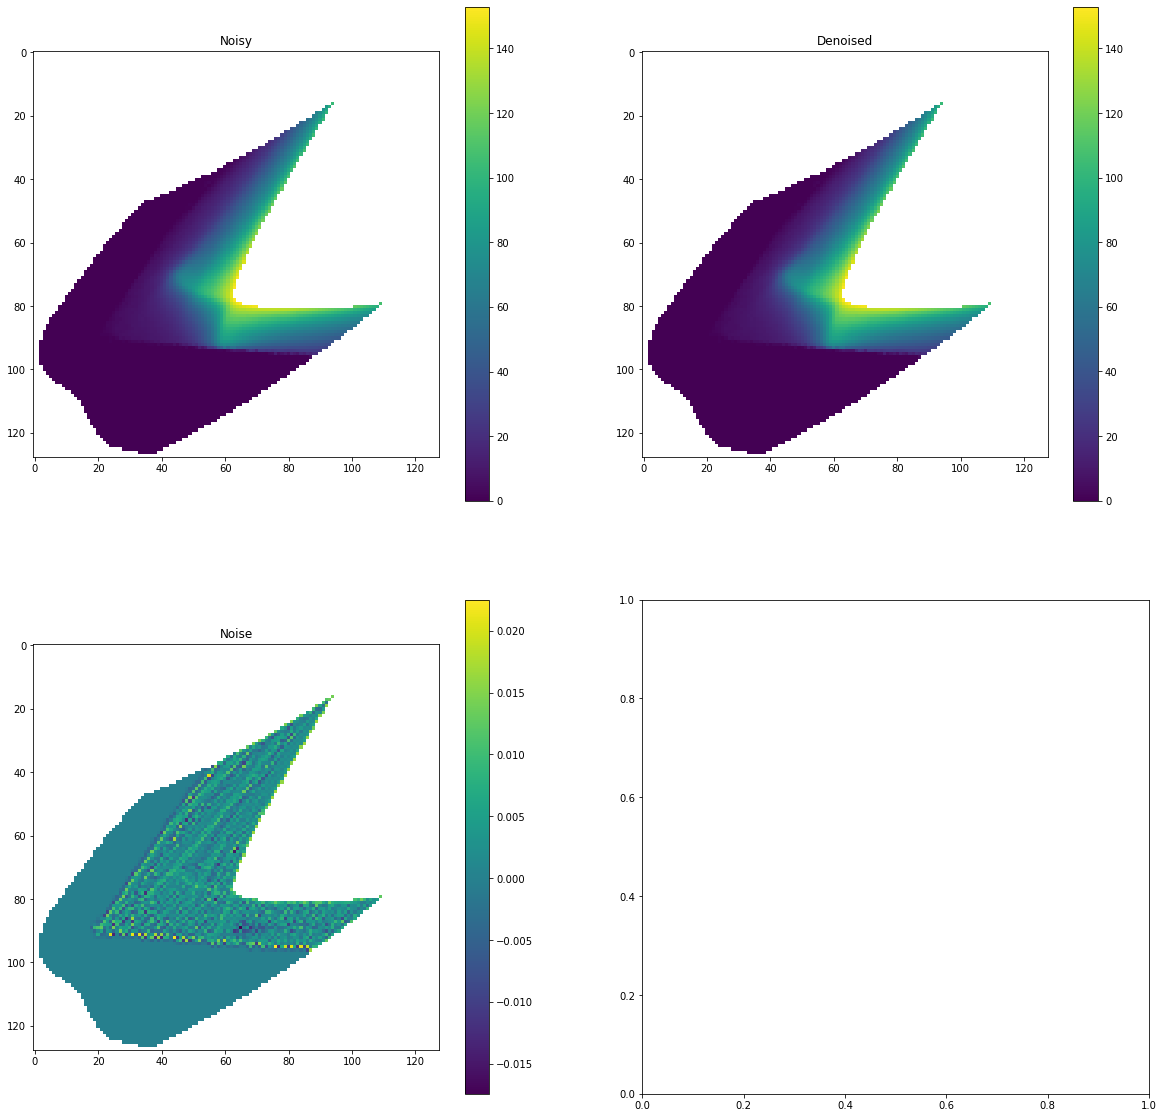

In [271]:
print("2D shift-invariant denoising took ", tok - tik, "seconds.")
compare_regplot(ogimg = img0_reg[:,0], denoised_img = denoised_reg[:,0] )
# compare_regplot(ogimg = img0_reg[:,1], denoised_img = denoised_reg[:,1])